In [10]:
%mkdir /content/calvin
%cd /content/calvin
!git clone https://github.com/mees/calvin_env.git
%cd /content/calvin/calvin_env
!git clone https://github.com/lukashermann/tacto.git
# Install packages 
%cd /content/calvin/calvin_env/tacto/
!pip3 install -e .
%cd /content/calvin/calvin_env
!pip3 install -e .



mkdir: cannot create directory ‘/content/calvin’: File exists
/content/calvin
fatal: destination path 'calvin_env' already exists and is not an empty directory.
/content/calvin/calvin_env
fatal: destination path 'tacto' already exists and is not an empty directory.
/content/calvin/calvin_env/tacto
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/calvin/calvin_env/tacto
  Using cached PyOpenGL-3.1.0-py3-none-any.whl
  Attempting uninstall: tacto
    Found existing installation: tacto 0.0.3
    Uninstalling tacto-0.0.3:
      Successfully uninstalled tacto-0.0.3
  Running setup.py develop for tacto
/content/calvin/calvin_env
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/calvin/calvin_env
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: 

In [11]:
# Run this to check if the installation was succesful
from calvin_env.envs.play_table_env import PlayTableSimEnv

In [12]:
%cd /content/calvin
from hydra import initialize, compose

with initialize(config_path="./calvin_env/conf/"):
  cfg = compose(config_name="config_data_collection.yaml", overrides=["cameras=static_and_gripper"])
  cfg.env["use_egl"] = False
  cfg.env["show_gui"] = False
  cfg.env["use_vr"] = False
  cfg.env["use_scene_info"] = True
  print(cfg.env)

/content/calvin


<ipython-input-12-0c7075c44180>:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="./calvin_env/conf/"):
/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_data_collection.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/hydra/core/default_element.py:124: UserWarning: In 'vr_input/vr_controller/vive': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(


{'_target_': 'calvin_env.envs.play_table_env.PlayTableSimEnv', '_recursive_': False, 'cameras': '${cameras}', 'seed': 0, 'bullet_time_step': 240.0, 'use_vr': False, 'show_gui': False, 'robot_cfg': '${robot}', 'scene_cfg': '${scene}', 'use_scene_info': True, 'use_egl': False, 'control_freq': 30}


dict_keys(['rgb_obs', 'depth_obs', 'robot_obs', 'scene_obs'])


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


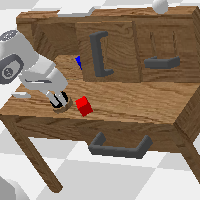

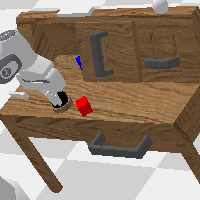

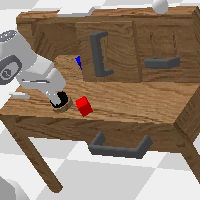

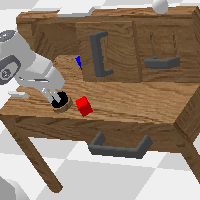

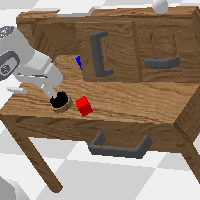

In [13]:
import time
import hydra
import numpy as np
from google.colab.patches import cv2_imshow

env = hydra.utils.instantiate(cfg.env)
observation = env.reset()
#The observation is given as a dictionary with different values
print(observation.keys())
for i in range(5):
  # The action consists in a pose displacement (position and orientation)
  action_displacement = np.random.uniform(low=-1, high=1, size=6)
  # And a binary gripper action, -1 for closing and 1 for oppening
  action_gripper = np.random.choice([-1, 1], size=1)
  action = np.concatenate((action_displacement, action_gripper), axis=-1)
  observation, reward, done, info = env.step(action)
  rgb = env.render(mode="rgb_array")[:,:,::-1]
  cv2_imshow(rgb)

In [14]:
from gym import spaces
from calvin_env.envs.play_table_env import PlayTableSimEnv

class SlideEnv(PlayTableSimEnv):
    def __init__(self,
                 tasks: dict = {},
                 **kwargs):
        super(SlideEnv, self).__init__(**kwargs)
        # For this example we will modify the observation to
        # only retrieve the end effector pose
        self.action_space = spaces.Box(low=-1, high=1, shape=(7,))
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7,))
        # We can use the task utility to know if the task was executed correctly
        self.tasks = hydra.utils.instantiate(tasks)

    def reset(self):
        obs = super().reset()
        self.start_info = self.get_info()
        return obs

    def get_obs(self):
        """Overwrite robot obs to only retrieve end effector position"""
        robot_obs, robot_info = self.robot.get_observation()
        return robot_obs[:7]

    def _success(self):
        """ Returns a boolean indicating if the task was performed correctly """
        current_info = self.get_info()
        task_filter = ["move_slider_left"]
        task_info = self.tasks.get_task_info_for_set(self.start_info, current_info, task_filter)
        return 'move_slider_left' in task_info

    def _reward(self):
        """ Returns the reward function that will be used 
        for the RL algorithm """
        reward = int(self._success()) * 10
        r_info = {'reward': reward}
        return reward, r_info

    def _termination(self):
        """ Indicates if the robot has reached a terminal state """
        success = self._success()
        done = success
        d_info = {'success': success}        
        return done, d_info

    def step(self, action):
            """ Performing a relative action in the environment
                input:
                    action: 7 tuple containing
                            Position x, y, z. 
                            Angle in rad x, y, z. 
                            Gripper action
                            each value in range (-1, 1)

                            OR
                            8 tuple containing
                            Relative Joint angles j1 - j7 (in rad)
                            Gripper action
                output:
                    observation, reward, done info
            """
            # Transform gripper action to discrete space
            env_action = action.copy()
            env_action[-1] = (int(action[-1] >= 0) * 2) - 1

            # for using actions in joint space
            if len(env_action) == 8:
                env_action = {"action": env_action, "type": "joint_rel"}

            self.robot.apply_action(env_action)
            for i in range(self.action_repeat):
                self.p.stepSimulation(physicsClientId=self.cid)
            obs = self.get_obs()
            info = self.get_info()
            reward, r_info = self._reward()
            done, d_info = self._termination()
            info.update(r_info)
            info.update(d_info)
            return obs, reward, done, info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
!pip install setuptools==65.5.0 pip==21
!pip install stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import gym
import numpy as np
from stable_baselines3 import SAC

new_env_cfg = {**cfg.env}
new_env_cfg["tasks"] = cfg.tasks
new_env_cfg.pop('_target_', None)
new_env_cfg.pop('_recursive_', None)
env = SlideEnv(**new_env_cfg)
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
disconnecting id 0 from server


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [19]:
def evaluate_model(model, env, num_episodes):
    episode_rewards = []
    for i in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

# Evaluate the model
evaluate_model(model, env, num_episodes=1)


Mean reward: 10.0, Std reward: 0.0
